In [ ]:
## List of things to do

Jessica
- Data Cleaning 
- Arch diagram
-Sentiment 
https://www.youtube.com/watch?v=OcbDsbKeh_c&feature=youtu.be
    

Ishaan
- Scraping timeline to get tweet, add follower count 
- Introduction 
- KEywords + hashtags  
    

### Introduction

- Get Tweet Data 
- Predict Hashtags based on tweets (based on words and image)
- Predict captions if only images and links 
- Tag emootion of tweet content 

## Table of contents

## Architecture Diagram

In [1]:
import requests
import urllib
import tweepy
import json
import csv
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import re
import io
import time

## Hashtag 

In [4]:
# Find most popular hashtags 

## Time 

In [3]:
#from retrying import retry

#@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def get_tweets():
    consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
    consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
    access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
    access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
    
    try:
        print("hello")
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)

        csvFile = open('final-project-tweets.csv', 'a')

        #Use csv writer
        csvWriter = csv.writer(csvFile)
        csvWriter.writerow(["category", "screen_name", "created_at", "text", "favorite_count", "retweet_count", "sentiment"])
        categories = ["Sports", "Politics", "Entertainment", "Education", "Technology", "Business"]
        dates = ["11-27", "11-28", "11-29", "11-30", "11-31", "12-1", "12-2", "12-3", "12-4"]
        for category in categories:
            for date in range(len(dates)-1):
                for tweet in tweepy.Cursor(api.search,q = category,since = "2019-"+dates[date],until = "2019-"+dates[date+1],lang = "en", result_type = 'popular').items():
                    # Write a row to the CSV file. I use encode UTF-8 
                    csvWriter.writerow([category, tweet.user.screen_name, tweet.created_at, tweet.text.encode('utf-8'), tweet.favorite_count, tweet.retweet_count])
                    print(category, tweet.user.screen_name, tweet.created_at, tweet.text.encode('utf-8'), tweet.favorite_count, tweet.retweet_count) #, tweet.get_tweet_sentiment(tweet.test))
                    time.sleep(.200)
                    #print (tweet.user.screen_name, tweet.created_at, tweet.text)
        csvFile.close()
    except tweepy.error.TweepError:
        raise
        
get_tweets()

hello
Sports NFL 2019-12-01 19:19:43 b'PUNTER TO KICKER TOUCHDOWN!\n\nThe @MiamiDolphins pull off the trickery! #PHIvsMIA\n\n\xf0\x9f\x93\xba: FOX\n\xf0\x9f\x93\xb1: NFL app // Yahoo Sports\xe2\x80\xa6 https://t.co/0xpJSZFo5B' 12251 2897
Sports NFL 2019-12-01 20:46:47 b'BLOCK. THAT. KICK.\n\nAnd take it all the way for a @Titans TOUCHDOWN! @TyeSmithCB #TENvsIND\n\n\xf0\x9f\x93\xba: CBS\n\xf0\x9f\x93\xb1: NFL app // Ya\xe2\x80\xa6 https://t.co/3Ua0DehHmR' 2446 634
Sports rapplerdotcom 2019-12-01 11:42:32 b"WATCH: Carlos Yulo's message to his supporters #SEAGames2019\nFull story: https://t.co/RHSi78XCz6 https://t.co/6nQ17elvcM" 42703 3561
Sports NFL 2019-12-01 20:58:23 b'Derrius Guice goes over the 100-yard mark for the first time in his career! @DhaSickest #HTTR #WASvsCAR\n\n\xf0\x9f\x93\xba: FOX\n\xf0\x9f\x93\xb1:\xe2\x80\xa6 https://t.co/Wi1IK4xK5Y' 2233 580
Sports NFL 2019-12-01 18:10:14 b'The @49ers score first!\n\n@JimmyG_10 to Deebo Samuel for 33 yards on 4th and 2! #GoNiners\n\n\

Sports FCBarcelona 2019-12-02 22:41:05 b'\xe2\x9a\xa1\xef\xb8\x8f The sports world hails Leo #Messi #BallonDor 2019\n\nhttps://t.co/nlecfumXqX' 14384 2244
Sports MattWalshBlog 2019-12-02 18:29:01 b'She just set female sports reporters back by 50 years \n\n https://t.co/xN3TOTTNDF' 11436 1744
Sports SriSri 2019-12-02 08:25:12 b'Felicitated distinguished sportspersons from 15 sports disciplines who have brought laurels to the country, at the\xe2\x80\xa6 https://t.co/DcBgUXYb0R' 2167 928
Sports NFL 2019-12-02 03:58:01 b'HOPKINS OPTION.\n\n@DeAndreHopkins tosses to @DeshaunWatson for the touchdown! #WeAreTexans\n\n\xf0\x9f\x93\xba: #NEvsHOU on NBC\n\xf0\x9f\x93\xb1: NF\xe2\x80\xa6 https://t.co/MJEqcsv3ac' 4129 981
Sports SkySportsBoxing 2019-12-02 13:15:25 b'\xf0\x9f\x93\xa3AJ ringwalk - 8.45pm - Saturday night\xe2\x80\xbc\n\n\xe2\x8f\xb0 Timings for fight night: \n\xf0\x9f\x93\xb2 4pm, Facebook &amp; YouTube \n\xf0\x9f\x93\xba 5pm, Sky Sports B\xe2\x80\xa6 https://t.co/VYeF7Ldd1U' 2930 74

Politics BBCRealityCheck 2019-12-01 13:46:25 b"Boris Johnson told #MarrShow the Queen's Speech - which set out his plans for government including a bill to preven\xe2\x80\xa6 https://t.co/0eXzn2oXQv" 18780 12442
Politics HamillHimself 2019-12-01 19:34:18 b"When I've had my fill of politics &amp; reality\xf0\x9f\x98\xa9- I find humor &amp; animals positivity therapeutic.\xf0\x9f\xa4\xa3 https://t.co/humdKdQ8zd" 40106 3751
Politics neal_katyal 2019-12-01 21:29:51 b"Only lawmaker to have worked 3 impeachment probes says Trump's Ukraine conduct 'more serious' than Nixon's Watergate https://t.co/mUJnqTehDa" 10482 3576
Politics FrankFigliuzzi1 2019-12-01 20:02:24 b'We\xe2\x80\x99ve reached the dangerous place where the military and their Commander in Chief don\xe2\x80\x99t trust each other: Trump\xe2\x80\x99s I\xe2\x80\xa6 https://t.co/CoUfGetiq6' 10722 4050
Politics peterbakernyt 2019-12-01 14:24:58 b"Accused of killing an unarmed, sedated captive, he held up the dead man's head by the hair

Politics JoeNBC 2019-12-02 00:17:50 b'\xf0\x9f\x9a\xa8\xf0\x9f\x9a\xa8\xf0\x9f\x9a\xa8\xe2\x80\x9cIn a classified briefing this fall, US intelligence officials told senators that Russia has engaged in a years-\xe2\x80\xa6 https://t.co/SECHSYlQHh' 3566 1509
Politics eliehonig 2019-12-02 00:44:16 b'Easier to cry victimhood than to mount an actual defense on the facts.  https://t.co/dtjj74YSs2' 7775 1732
Politics FAIRImmigration 2019-12-02 00:00:05 b'Progressives decry fake ICE university \xe2\x80\x93 turns out it was created under President Obama https://t.co/XiKkIiMqj6 via @FoxNews' 1898 917
Politics cnnbrk 2019-12-02 00:46:08 b"Neither the President nor his attorneys will participate in Wednesday's House Judiciary impeachment hearing, they s\xe2\x80\xa6 https://t.co/4C84i2OM4g" 1907 625
Politics ABC 2019-12-02 00:32:21 b'NEW: Pres. Trump and his lawyers will not participate in Wednesday\xe2\x80\x99s impeachment hearing in the House Judiciary Com\xe2\x80\xa6 https://t.co/WMqGIk5sUi' 538

Entertainment rapplerdotcom 2019-12-01 07:30:05 b"'Imagine being more concerned with 'ruining' a perfectly happy family instead of being a good leader,' Frankie Pang\xe2\x80\xa6 https://t.co/DjcnrbvDhu" 6402 778
Entertainment BreitbartNews 2019-12-01 00:16:37 b'Supreme Court Justice Clarence Thomas said \xe2\x80\x9cthe modern-day liberal\xe2\x80\x9d has proven to be a bigger \xe2\x80\x9cimpediment\xe2\x80\x9d than tho\xe2\x80\xa6 https://t.co/la0o5BcN3i' 5806 2346
Entertainment Koreaboo 2019-12-01 23:50:00 b'CL Reveals She Is "Excited For The First Time In A Long Time" After Leaving YG Entertainment\n\nhttps://t.co/4KaxkkSlxh' 2118 342
Entertainment MikeMav22 2019-12-01 23:25:39 b'The most electrifying move in sports entertainment. https://t.co/HHokWxkffl' 1879 281
Entertainment Bucks 2019-12-01 02:04:27 b'For your entertainment. \n\n#FearTheDeer https://t.co/XCeJw5Nl91' 2336 414
Entertainment BreitbartNews 2019-12-01 15:47:48 b'(No word yet on whether they will vow to never fly again,

Entertainment rapplerdotcom 2019-12-03 05:35:12 b'We have decided to stan. \xf0\x9f\x99\x8c\xf0\x9f\x8f\xbb\n\nActress Angel Locsin has been recognized for her philanthropic work as she made it to\xe2\x80\xa6 https://t.co/41ht35JlCS' 3565 593
Entertainment rapplerdotcom 2019-12-03 04:52:36 b'Not all heroes wear capes!\n\nActress Angel Locsin has been recognized in Forbes Magazine\'s annual "Heroes of Philant\xe2\x80\xa6 https://t.co/jFpp8il0Ju' 3726 602
Entertainment taran_adarsh 2019-12-03 15:03:42 b'#Update: Biopic\xc2\xa0on #Indian mathematician Vashistha Narayan Singh announced... Directed by\xc2\xa0Neeraj Pathak... Produced by Excel Entertainment.' 4267 204
Entertainment ABSCBN 2019-12-03 08:05:00 b'To celebrate the fourth anniversary of Tonight With Boy Abunda, netizens were given the chance to choose their favo\xe2\x80\xa6 https://t.co/JsNldcsoAk' 1335 446
Entertainment GeethaArts 2019-12-03 10:55:29 b'108 Shots of Celebration &amp; 136 Seconds of Entertainment Loading \xf0\x9f\

Education KentPage 2019-12-01 03:00:03 b'#EducationCannotWait for any child. \nPlease RT if you agree! \n\n@EduCannotWait: the first global multilateral fund d\xe2\x80\xa6 https://t.co/VEZ28ullMQ' 77 50
Education rais_shk 2019-12-01 03:46:28 b'Our initiative : Free &amp; Quality Education Project @ UMR Mum. Public School. Inspiring example of Public Pvt. Partne\xe2\x80\xa6 https://t.co/zYftVhQuVV' 216 41
Education profmusgrave 2019-12-01 04:11:36 b'US News and World Report died years ago but survives as a poltergeist to curse American higher education' 356 39
Education SuellaBraverman 2019-12-01 00:29:34 b'Reasons to vote @Conservatives #GE2019 \nReason Number 10: ALL Fareham schools will receive increased per pupil fund\xe2\x80\xa6 https://t.co/0Kc2lD0mWu' 99 22
Education santoshspeed 2019-12-01 04:29:55 b'What can stop these heinous crimes: \n\n-Justice must be delivered in months not yrs.\n\n-Reform education &amp; teach kids\xe2\x80\xa6 https://t.co/9MbCJPJsLp' 88 39
Education egav

Education Jkylebass 2019-12-03 15:34:30 b'There is a $100MM loan on the WB\xe2\x80\x99s balance sheet directly to Xinjiang for \xe2\x80\x9ceducation\xe2\x80\x9d facilities. THE WORLD BANK HA\xe2\x80\xa6 https://t.co/upSDBtiMsx' 1215 522
Education drshamamohd 2019-12-03 14:27:23 b"Didn't the #BJP govt realise it had no funds before announcing its Rs 2,600-crore education plan for J&amp;K and Ladakh\xe2\x80\xa6 https://t.co/hV6ap1mwg4" 548 315
Education KamalaHarris 2019-12-03 00:05:39 b'We\xe2\x80\x99ve placed a societal value on jobs that require a college education, while devaluing the jobs that don\xe2\x80\x99t.\n\nIn a\xe2\x80\xa6 https://t.co/4MlF9lD39p' 2000 540
Education GavinWilliamson 2019-12-03 09:26:07 b'PISA results show our standing rising strongly.\n\n@Conservatives reforms are working &amp; deliver greater opportunity f\xe2\x80\xa6 https://t.co/a4xfuIZ92n' 859 331
Education DjokerNole 2019-12-03 16:25:29 b'Giving is all about love \xe2\x9d\xa4 We welcome you to join us in

Technology samhowzit 2019-12-02 02:36:16 b'Today I found a Kodak PhotoCD from my visit to #WaltDisneyWorld in late Dec. 1994. It got me thinking about obsolet\xe2\x80\xa6 https://t.co/4PWiT2bEW3' 454 49
Technology EFF 2019-12-02 00:15:00 b'From smart doorbells watching Halloween Trick-or-Treating to daily school monitoring, children should not have to l\xe2\x80\xa6 https://t.co/vb1HuquKlZ' 61 39
Technology sunlorrie 2019-12-02 03:00:52 b"That's a real concern if we use Huawei for G5 technology. https://t.co/Ho7UF0Co98" 35 24
Technology rosenbergerlm 2019-12-02 01:09:21 b'This is why democracies need to think through whether proposed approaches to information manipulation actually play\xe2\x80\xa6 https://t.co/96E0VwGsOf' 53 33
Technology CBCNews 2019-12-02 03:00:39 b'The air industry knows it has a carbon footprint problem - so what is it doing about it? https://t.co/fNI464iVaY' 51 21
Technology TheEconomist 2019-12-02 00:08:36 b'How ear bones evolved https://t.co/8s5D1gKLmw' 53 27
Tec

Business DanCrenshawTX 2019-12-01 20:05:01 b'Maybe these 11,000 \xe2\x80\x9cscientists\xe2\x80\x9d could contribute to the already very promising science of carbon capture technology\xe2\x80\xa6 https://t.co/9ROJN4Veo8' 13191 2861
Business business 2019-12-01 00:39:26 b'Sri Lanka wants to undo a $1.1 billion deal to lease a port to China for 99 years https://t.co/YvjNRPmOQE' 1282 1116
Business UN 2019-12-01 14:05:00 b"She's our one and only planet. Let's treat her better.\n\nAs world &amp; business leaders arrive in Madrid, Spain togethe\xe2\x80\xa6 https://t.co/X0nB4k8mw7" 2203 1294
Business milinddeora 2019-12-01 11:47:41 b'I have always known Rahul Bajaj to be apolitical, fiercely nationalistic &amp; brutally honest. His remarks yesterday a\xe2\x80\xa6 https://t.co/4TYyaniye5' 1812 323
Business RMantri 2019-12-01 05:44:58 b'There is a class undertone to this. Most business family patriarchs feel they are far above individuals like Narend\xe2\x80\xa6 https://t.co/HwCuf98JmU' 471 272


Business paulmozur 2019-12-03 09:03:03 b'In Xinjiang, Chinese police are using the blood and faces of an oppressed minority to craft dystopian technologies\xe2\x80\xa6 https://t.co/2LK5bEoeWh' 5609 5348
Business EpochTimes 2019-12-03 03:10:01 b'6 out of 10 small business owners approve of President Trump\xe2\x80\x99s handling of his job, according to a recently release\xe2\x80\xa6 https://t.co/x5gETiYAfe' 762 586
Business AnandWrites 2019-12-03 22:31:57 b'The moral meltdown of McKinsey is one of the more devastating business stories of our era, and evidence of a deeper\xe2\x80\xa6 https://t.co/zGZcUFtZzn' 1895 820
Business cvpayne 2019-12-03 18:49:05 b"I'm in DC were I just wrapped an exclusive interviewed Vice President Mike Pence\n\nWe covered wide wide range of top\xe2\x80\xa6 https://t.co/rOYklIFao3" 6141 1489
Business HawleyMO 2019-12-03 21:11:04 b'#China using DNA to create facial images to track dissidents &amp; ethnic minorities. This is the millionth reason why\xe2\x80\xa6 htt

In [96]:
data = pd.read_csv("final-project-tweets.csv") 
#print(len(data))
data.head()
#print(data)

,category,screen_name,created_at,text,favorite_count,retweet_count
0,Sports,Kenny_Mayne,2019-11-27 22:36:16,b'To be silent about a former MLB player posti...,20030,3007
1,Sports,globaltimesnews,2019-11-27 03:27:54,"b'#GodfreyGao, an actor from #Taiwan island, d...",2972,1653
2,Sports,SkySportsNews,2019-11-27 12:22:06,b'BREAKING: Temporary substitutions for player...,6446,869
3,Sports,SashaBanksWWE,2019-11-27 14:42:45,"b'Sports entertainer, professional wrestler, s...",12168,1323
4,Sports,Hawk,2019-11-27 21:56:01,b'Greatest sports broadcasting moment of this ...,5223,976


In [97]:
data['created_at'] = pd.DatetimeIndex(data['created_at'])
#print(data)
data['created_at'] = data['created_at'].dt.time.astype(str)
#print(data)
data['created_at'] = pd.DatetimeIndex(data['created_at'])
#print(data)
#print(data['created_at'].dtype)

In [98]:
#print(data)
groups = data.groupby(['category'])
#for key, value in groups:
    #print(key, value)
category = groups.get_group("Politics")
time_grpr = category.groupby(pd.Grouper(key='created_at', freq='10min'))
#groups = groups.get_group("Politics").groupby(pd.Grouper(key='created_at', freq='10min'))
#for key, value in time_grpr:
    #print(key, value)
#time_grpr_retweet = groups['retweet_count','favorite_count'].sum()
#print(time_grpr_retweet)
#time_grpr_retweet['created'] = time_grpr_retweet.index"""
sum_grpr = time_grpr['favorite_count', 'retweet_count'].sum()
sum_grpr['tmpstmp'] = sum_grpr.index
sum_grpr['count'] = time_grpr['text'].count()
#print(sum_grpr)
sum_grpr['avg_favorites'] = sum_grpr['favorite_count']/sum_grpr['count']
sum_grpr['avg_retweets'] = sum_grpr['retweet_count']/sum_grpr['count']
sum_grpr = sum_grpr.fillna(0)
print(sum_grpr)

                     favorite_count  retweet_count             tmpstmp  count  \
created_at                                                                      
2019-12-04 00:00:00           24824           6428 2019-12-04 00:00:00     21   
2019-12-04 00:10:00           15866           5221 2019-12-04 00:10:00     14   
2019-12-04 00:20:00           18155           4347 2019-12-04 00:20:00     15   
2019-12-04 00:30:00           31847           9317 2019-12-04 00:30:00      9   
2019-12-04 00:40:00           21251           5779 2019-12-04 00:40:00      6   
2019-12-04 00:50:00            1970           1260 2019-12-04 00:50:00      4   
2019-12-04 01:00:00           33396           9330 2019-12-04 01:00:00      7   
2019-12-04 01:10:00            6358            919 2019-12-04 01:10:00      3   
2019-12-04 01:20:00           61680          16946 2019-12-04 01:20:00      3   
2019-12-04 01:30:00           18248           6177 2019-12-04 01:30:00      4   
2019-12-04 01:40:00         

AttributeError: 'Series' object has no attribute 'arg_max'

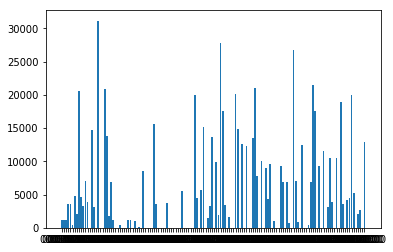

In [99]:
#sum_grpr.index.astype('timedelta64[s]')
sum_grpr['tmpstmp'] = sum_grpr['tmpstmp'].dt.time.astype(str)
plt.bar(sum_grpr['tmpstmp'],height=sum_grpr['avg_favorites'])
#max_time = sum_grpr['avg_favorites'].arg_max()
#print(sum_grpr[max_time])